In [1]:
import pandas as pd
import numpy as np

from ucimlrepo import fetch_ucirepo

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

## Classification :: Bank Marketing, predict if the client will subscribe a term deposit

In [2]:
bank_marketing = fetch_ucirepo(name='Bank Marketing')

In [3]:
print(bank_marketing.metadata.get('additional_info').get('variable_info'))

Input variables:
   # bank client data:
   1 - age (numeric)
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   5 - default: has credit in default? (binary: "yes","no")
   6 - balance: average yearly balance, in euros (numeric) 
   7 - housing: has housing loan? (binary: "yes","no")
   8 - loan: has personal loan? (binary: "yes","no")
   # related with the last contact of the current campaign:
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  10 - day: last contact day of the month (numeric)
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "no

In [4]:
df_bank_marketing = bank_marketing.data.get('original')

In [5]:
df_bank_marketing.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
38191,34,blue-collar,married,secondary,no,2139,yes,no,cellular,15,may,1452,1,-1,0,NaN,no
29459,58,retired,married,primary,no,3401,yes,no,cellular,3,feb,84,3,265,2,failure,no
23116,34,technician,single,secondary,no,1974,no,no,cellular,26,aug,603,3,-1,0,NaN,no
19260,34,management,married,tertiary,no,0,no,no,cellular,6,aug,139,2,-1,0,NaN,no
37789,23,blue-collar,single,secondary,no,1105,yes,no,cellular,14,may,377,1,-1,0,NaN,no


# 1. Check the distribution of the Dependent Variable
---

<big>

Watch out for **class imbalance**!

If the incidence of the positive class is less than 5% there is *severe imbalance*
Examples include Fraud, Campaign Clicks, Loan Defaults
- In such cases, select an appropriate performance metric (`accuracy` will be misleading)
- Try different model strategies: Tree-based, Neighbours, SVM etc.
- Diagnose the problems using the *Confusion Matrix* - are there too many FPs or FNs?
- Try Ensemble Methods both automated (like Random Forest) and manual (panel of models casting votes)

<br>

In [ ]:
df_bank_marketing['y'].value_counts(normalize=True).round(2)

# Explore the data
---

<big>

References:

1. [Visualizing distributions of data](https://seaborn.pydata.org/tutorial/distributions.html) with `distplot`, `jointplot`, `pairplot`
2. [Visualizing categorical data](https://seaborn.pydata.org/tutorial/categorical.html) 
3. [Estimating regression fits](https://seaborn.pydata.org/tutorial/regression.html) with `regplot` or `lmplot`

More specifically, try these

- [$displot()$](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot): visualizing the **univariate or bivariate distribution** of data using histograms, kde plots or CDFs
- [$relplot()$](https://seaborn.pydata.org/generated/seaborn.relplot.html#seaborn.relplot): show the relationship between **two numerical variables** with scatter or line plots
- [$catplot()$](https://seaborn.pydata.org/generated/seaborn.catplot.html#seaborn.catplot): show the relationship between **a numerical and one or more categorical variables** using boxplots, barplots and more
- [$lmplot()$](https://seaborn.pydata.org/generated/seaborn.lmplot.html#seaborn.lmplot): fits **regression models** across conditional subsets of a dataset



In [ ]:
df_bank_marketing = df_bank_marketing.assign(likelihood_term_deposit=lambda fr: fr['y'].map({'yes': 1, 'no': 0}))

In [ ]:
sns.barplot(data=df_bank_marketing, x='likelihood_term_deposit', y='education', hue='marital');

In [ ]:
sns.displot(data=df_bank_marketing, x='age', binwidth=5);

In [ ]:
sns.countplot(data=df_bank_marketing, y='job', hue='y');

In [ ]:
f"The avg. likelihood of opening a Term Deposit is: {df_bank_marketing['likelihood_term_deposit'].mean():.2%}"

In [ ]:
df_bank_marketing['y'].value_counts(normalize=True)

In [ ]:
df_bank_marketing.groupby('job')['y'].value_counts(normalize=True)

In [ ]:
pd.concat([
    (df_bank_marketing
     .reset_index()
     .pivot_table(index=col, columns='y', values='index', aggfunc='count')
     .eval("pct_yes=yes/(no+yes)")
     .sort_values('pct_yes')
     .rename(index=lambda i: f"{col}_{i}")
     .tail()) 
    for col 
    in df_bank_marketing.select_dtypes(include=pd.Categorical).fillna('Unknown').drop(columns='y').columns.values
]).sort_values('pct_yes')

In [ ]:
df_bank_marketing.groupby(df_bank_marketing['previous'].clip(upper=6))['likelihood_term_deposit'].mean()

# Prepare data for modeling
---

<big>

- Make dummies for categoricals
- Standardize numeric data
- (optional) Run feature selection

<br>

In [7]:
df_x = \
(df_bank_marketing
    .drop(columns=['y'])
    .copy()
)

In [8]:
df_x_categorical = \
pd.concat([
    pd.get_dummies(df_x.loc[:, col], prefix=col, drop_first=True).astype(int)
    for col 
    in df_x.select_dtypes(include=pd.Categorical).columns
], axis=1).fillna('MISSING')

In [9]:
df_x_numeric = \
(df_x
    .select_dtypes(include=np.number)
    .apply(lambda col: col.subtract(col.mean()).divide(col.std()))
).fillna(0)

In [10]:
X = pd.concat([df_x_numeric, df_x_categorical], axis=1)

In [12]:
y = df_bank_marketing['y'].map({'yes': 1, 'no': 0})

# Split Datasets
---

<br>

In [20]:
from sklearn.model_selection import train_test_split

In [45]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.75, random_state=1123)

In [48]:
y_tr.mean().round(2), y_te.mean().round(2)

(np.float64(0.12), np.float64(0.12))

# Feature Selection
---

<br>

In [49]:
from sklearn.feature_selection import SelectKBest, f_classif

In [50]:
skb = SelectKBest(k=15)
skb.fit(X_tr, y_tr)

,score_func,<function f_c...t 0x11a0ec720>
,k,15


<Axes: ylabel='feature'>

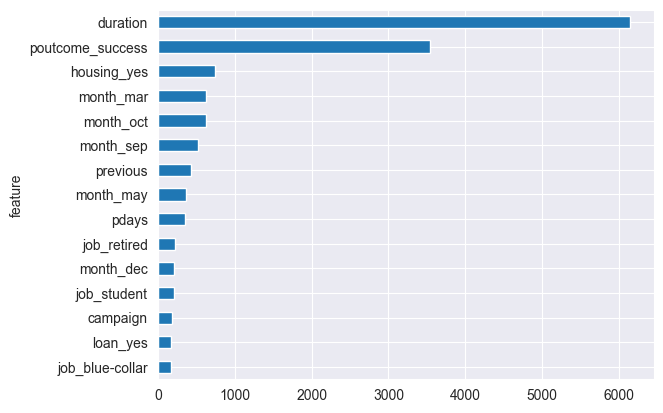

In [54]:
pd.DataFrame({
    'feature': skb.feature_names_in_,
    'score': skb.scores_,
    'pvalue': skb.pvalues_
}).set_index('feature').round(2).sort_values('score').loc[:, 'score'].tail(15).plot.barh()

# X_tr_skb, X_te_skb = X_tr.loc[:, skb.get_feature_names_out()], X_te.loc[:, skb.get_feature_names_out()]

In [55]:
skb.get_feature_names_out()

array(['duration', 'campaign', 'pdays', 'previous', 'job_blue-collar',
       'job_retired', 'job_student', 'housing_yes', 'loan_yes',
       'month_dec', 'month_mar', 'month_may', 'month_oct', 'month_sep',
       'poutcome_success'], dtype=object)

# Import Model Class, Grid Search & Performance Metrics
---

<br>

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
from mdxclf.visualize import plot_confusion_matrix

In [22]:
dict_grid = {
    'max_depth': [5, 10, 12, 15],
    'min_samples_split': [150, 200, 250]
}

gscv = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced'), 
    param_grid=dict_grid, 
    scoring='accuracy', 
    cv=10, 
    n_jobs=-1, 
    verbose=True
)

In [23]:
gscv.fit(X_tr, y_tr)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


,estimator,DecisionTreeC...ht='balanced')
,param_grid,"{'max_depth': [5, 10, ...], 'min_samples_split': [150, 200, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,10
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [24]:
pd.DataFrame(gscv.cv_results_).set_index('params').loc[:, 'mean_test_score':].sort_values('rank_test_score')

,mean_test_score,std_test_score,rank_test_score
params,,,
"{'max_depth': 12, 'min_samples_split': 150}",0.817352,0.010149,1
"{'max_depth': 12, 'min_samples_split': 200}",0.816136,0.008563,2
"{'max_depth': 15, 'min_samples_split': 150}",0.814615,0.006323,3
"{'max_depth': 12, 'min_samples_split': 250}",0.813896,0.009273,4
"{'max_depth': 15, 'min_samples_split': 200}",0.812016,0.007853,5
"{'max_depth': 15, 'min_samples_split': 250}",0.809970,0.008328,6
"{'max_depth': 10, 'min_samples_split': 150}",0.807205,0.009345,7
"{'max_depth': 10, 'min_samples_split': 200}",0.805878,0.008188,8
"{'max_depth': 10, 'min_samples_split': 250}",0.803722,0.010269,9


In [25]:
print("Training Performance")
print(classification_report(y_tr, gscv.predict(X_tr)))
print(confusion_matrix(y_tr, gscv.predict(X_tr)))

Training Performance
              precision    recall  f1-score   support

           0       0.98      0.84      0.90     31937
           1       0.42      0.88      0.57      4231

    accuracy                           0.84     36168
   macro avg       0.70      0.86      0.73     36168
weighted avg       0.92      0.84      0.86     36168

[[26715  5222]
 [  499  3732]]


In [26]:
print("Test Performance")
print(classification_report(y_te, gscv.predict(X_te)))
print(confusion_matrix(y_te, gscv.predict(X_te)))

Test Performance
              precision    recall  f1-score   support

           0       0.97      0.83      0.90      7985
           1       0.39      0.84      0.54      1058

    accuracy                           0.83      9043
   macro avg       0.68      0.83      0.72      9043
weighted avg       0.91      0.83      0.85      9043

[[6623 1362]
 [ 171  887]]


Normalized confusion matrix


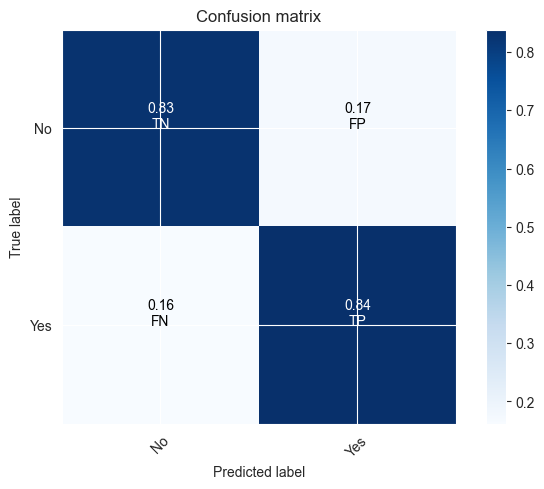

In [32]:
plot_confusion_matrix(cm=confusion_matrix(y_te, gscv.predict(X_te)), 
                      classes=['No', 'Yes'], 
                      normalize=True);

# Activity
---

<big>

- Try a model from the list below
- A grid is suggested, but feel free to change it
- Run GridSearchCV and report the performance

<br>

# The `.predict_proba()` method and the Threshold
---

0    0.12
1    0.76
2    0.58
3    0.76
4    0.01
Name: P1, dtype: float64

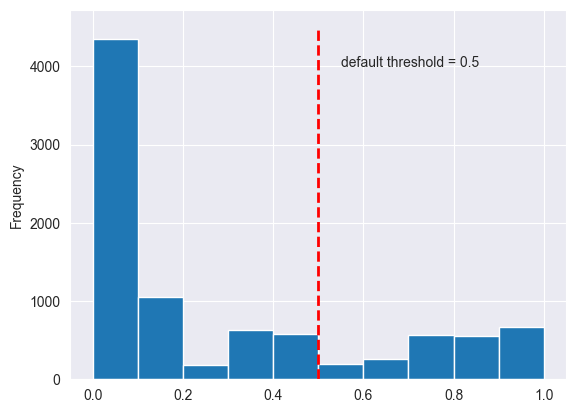

In [35]:
srs_probabilities = \
(pd.DataFrame(data=gscv.predict_proba(X_te), 
              columns=['P0', 'P1']).loc[:, 'P1'])

display(srs_probabilities.round(2).head())

ax = srs_probabilities.plot.hist()
ax.vlines(x=0.5, ymin=0, ymax=4500, color='red', linestyle='dashed', linewidth=2)
ax.annotate('default threshold = 0.5', (0.55, 4000));

# Impact of Changing the Threshold
---

<br>

In [36]:
from ipywidgets.widgets import FloatSlider, interact

In [37]:
def f(threshold):
    plot_confusion_matrix(cm=confusion_matrix(y_te, srs_probabilities.gt(threshold).astype(int)), classes=['No', 'Yes'], normalize=True)

interact(
    f,
    threshold=FloatSlider(value=0.5, min=0.3, max=0.8, step=0.05)
)

interactive(children=(FloatSlider(value=0.5, description='threshold', max=0.8, min=0.3, step=0.05), Output()),…

<function __main__.f(threshold)>

# Precision-Recall Curve
---

- helps find the threshold for optimum results

<br>

In [38]:
from sklearn.metrics import precision_recall_curve, roc_curve

In [39]:
p, r, t = precision_recall_curve(y_te, srs_probabilities, pos_label=1)

df_pr = (pd.DataFrame(data=zip(p, r, t),
                      columns=["precision", "recall", "threshold"])
         .set_index("threshold")
         .loc[0.5:0.9]
        )

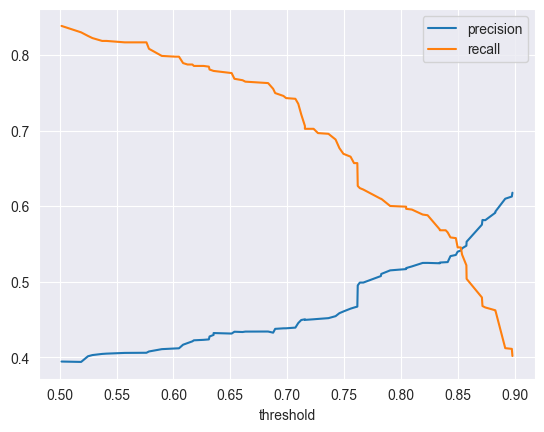

In [40]:
df_pr.plot();

# Ensembles with Pipelines
---

<big>

- Try to build multiple classifiers
- Get them to vote and try to reduce the False Positives

We will use `sklearn.Pipeline` to simplify the process

<br>